Tom Halloin <br> Springboard Data Science Career Track <br>

<h1 align="center">Capstone Project 2: Analysis of Berkshire Hathaway Shareholder Letters Using Natural Language Processing (NLP) Techniques</h1>

<h3 align='center'> Part 5: Topic Modelling</h3> <br>

This notebook tries to create a topic model visualization of Berkshire Hathaway's annual letters. Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

In [1]:
import gensim
import matplotlib.pyplot as plt
import nltk
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim
import re
import spacy
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.notebook import tqdm

Preprocessing: Loading English language Spacy model. Adding stop words that have showed up in previous iterations that are ambiguous or not helpful.

In [2]:
nlp = spacy.load('en_core_web_sm')

# Adding several stop words that showed up in original topics. Pronouns in general are not helpful and ambiguous.
nlp.Defaults.stop_words |= {'berkshire', 'berkshires', 'billion', 'million', 'that', 'they', 'this', 'which', 'what', 'year'}
stop_words = nlp.Defaults.stop_words

Loading all of the annual letters that are stored in a dictionary - cleaned from preprocessing earlier.

In [3]:
annual_letters = dict()
for year in range(1977, 2020):
    file = f'../clean_letters/{year}_letter.txt'
    with open(file=file, encoding='utf-8', errors='remove') as f:
        annual_letters[str(year)] = str(f.readlines())    

Creating a list of potential topics, stored by entity. Starts with tokenizing documents, then extracting entities, removing special characters such as punctutation and the dreaded non-breaking space (nbsp). Then filtering topics to make sure topic is at least 4 characters long and not a stop word.

In [4]:
text_data = []
# Iterates through each article in the corpus.
for year in tqdm(annual_letters):
    # Passes that article through the pipeline and adds to a new list.
    tokenized_letter = nlp(annual_letters[year])
    entities = [str(ent).lower() for ent in tokenized_letter.ents if ent.label_ != 'MONEY']
    ents_without_numbers = [re.sub('[,$%0-9.;&()]', '', ent) for ent in entities]
    remove_non_breaking_spaces = [re.sub('(nbsp)', '', ent) for ent in ents_without_numbers]
    potential_words = [chunk for chunk in remove_non_breaking_spaces if len(chunk) > 3]
    potential_words = [topic for topic in potential_words if topic not in stop_words]
    text_data.append(potential_words)

Creating a dictionary from the data, then convert to bag-of-words corpus using the gensim corpora package.

In [5]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

Computing coherence scores to measure quality of topics. Higher score -> more cohesive topics.

In [6]:
coherence_model_scores = []
for n in tqdm(range(5, 25)):
    model=gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=n, passes=25)
    coherence_model_lda = CoherenceModel(model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_model_scores.append(coherence_model_lda.get_coherence())

Plotting the coherence scores based on the number of topics.

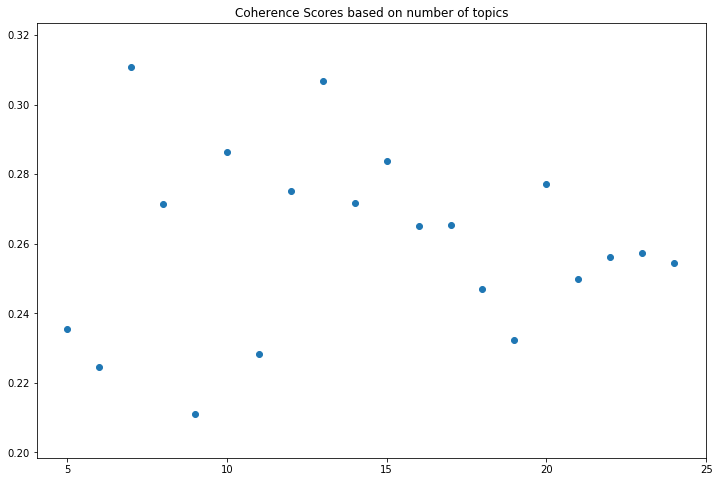

In [7]:

f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

Creating the actual topic model. Put num_topics as the value with one of the highest coherence scores, or a really low number if topics are too sparse.

In [8]:
NUM_TOPICS = coherence_model_scores.index(max(coherence_model_scores)) + 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = NUM_TOPICS)

In [9]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis


C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.007154 -0.007084       1        1  41.532558
0      0.008673  0.013296       2        1  25.274103
1      0.006823 -0.006501       3        1  19.212172
2     -0.000122  0.002138       4        1  11.456272
4     -0.001776 -0.002852       5        1   2.406135
5     -0.005837 -0.001113       6        1   0.087996
6     -0.014915  0.002117       7        1   0.030764, topic_info=     Category        Freq            Term       Total  loglift  logprob
407   Default  543.000000         charlie  543.000000  30.0000  30.0000
57    Default  528.000000       last year  528.000000  29.0000  29.0000
116   Default  245.000000          about   245.000000  28.0000  28.0000
9     Default  323.000000          annual  323.000000  27.0000  27.0000
172   Default  198.000000          second  198.000000  26.0000  26.0000
...       ...         ...             ...         ...      ...      ...
2520   Topic7    0.013906      general re   52.324615  -0.1463  -6.0914
105    Topic7    0.019405        the year  111.278946  -0.5677  -5.7581
300    Topic7    0.014780         america   64.316071  -0.2917  -6.0304
850    Topic7    0.015060  less than zero   92.612656  -0.6376  -6.0116
3084   Topic7    0.014201         clayton   87.259514  -0.6367  -6.0703

[576 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
475       1  0.527843       acres
475       2  0.527843       acres
1182      1  0.458013   am to  pm
1182      2  0.193775   am to  pm
1182      3  0.211391   am to  pm
...     ...       ...         ...
396       1  0.541505        zero
396       2  0.141262        zero
396       3  0.188350        zero
396       4  0.070631        zero
396       5  0.023544        zero

[882 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 5, 6, 7])

To compare, I am also going to use Mallet LDA. Mallet is known to provide better topics.

In [10]:

## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'C:/Users/Tom/Documents/Berkshire/Milestone_1/mallet-2.0.8'})
## Setup mallet path change it according to your drive
mallet_path = 'C:/Users/Tom/Documents/Berkshire/Milestone_1/mallet-2.0.8/bin/mallet'



In [11]:
coherence_model_scores = []
for n in tqdm(range(5, 25)):
    model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=dictionary)
    coherence_model_mallet = CoherenceModel(model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_model_scores.append(coherence_model_mallet.get_coherence())

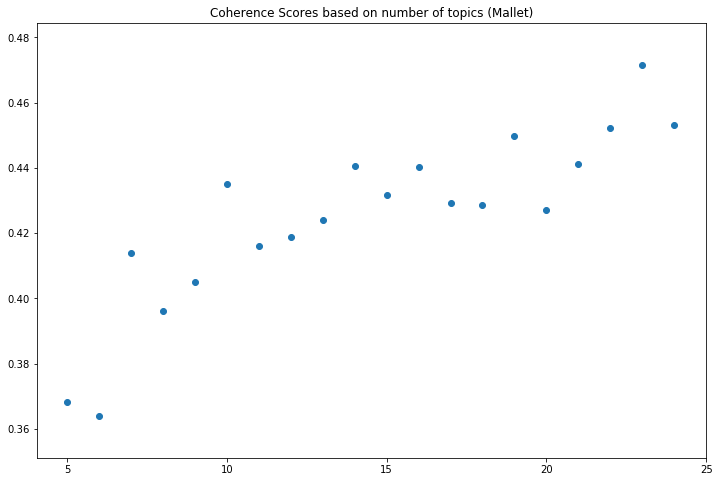

In [12]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics (Mallet)')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

In [13]:
NUM_TOPICS = 10 # After testing, this provided the "best" topics
model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
ldamodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.014119  0.256868       1        1  16.268622
0      0.225164  0.117778       2        1  16.172792
2      0.233091 -0.017703       3        1  10.461085
4      0.226563 -0.004695       4        1  10.117224
9      0.130897  0.062333       5        1   9.264480
5     -0.140633  0.070155       6        1   9.216854
3     -0.272488  0.027657       7        1   9.028103
8     -0.286619 -0.049127       8        1   7.325497
7     -0.242810 -0.063073       9        1   7.200092
1      0.112716 -0.400194      10        1   4.945251, topic_info=     Category         Freq        Term        Total  loglift  logprob
395   Default  1504.000000       years  1504.000000  30.0000  30.0000
9     Default   502.000000      annual   502.000000  29.0000  29.0000
7     Default   236.000000    american   236.000000  28.0000  28.0000
1218  Default   383.000000     company   383.000000  27.0000  27.0000
219   Default   228.000000       geico   228.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
134   Topic10    18.082165       frank    58.623378   1.8305  -4.0008
19    Topic10    19.373748  california    78.416715   1.6086  -3.9318
47    Topic10    18.082165        john   111.826132   1.1847  -4.0008
137   Topic10     9.041082      george    27.366922   1.8992  -4.6940
1755  Topic10    10.332666        post   103.841637   0.6992  -4.5604

[752 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1523      9  0.763949  -year-old
4551      3  1.331978      //-//
478       8  1.092486       \tis
3202      1  1.006393       abel
1793      3  1.331978       abes
...     ...       ...        ...
395       5  0.046532      years
395       6  0.132282      years
395       7  0.302455      years
395       8  0.197427      years
395       9  0.163525      years

[810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 5, 10, 6, 4, 9, 8, 2])

In [14]:
# Printing the words and weights for each part of the topic model.
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.097*"charlie" + 0.056*"gaap" + 0.051*"bnsf" + 0.045*"annual" + '
  '0.042*"omaha" + 0.032*"annually" + 0.031*"millions" + 0.030*"heinz" + '
  '0.028*"today" + 0.021*"marmon"'),
 (1,
  '0.108*"company" + 0.061*"hathaway" + 0.055*"berkshire’s" + 0.052*"wesco" + '
  '0.050*"annually" + 0.046*"corporation" + 0.041*"bank" + 0.038*"illinois" + '
  '0.034*"phil" + 0.027*"companies"'),
 (2,
  '0.092*"charlie" + 0.057*"gillette" + 0.055*"coca-cola" + 0.042*"company" + '
  '0.042*"borsheims" + 0.036*"coke" + 0.034*"gaap" + 0.029*"usair" + '
  '0.029*"washington" + 0.026*"april"'),
 (3,
  '0.252*"years" + 0.109*"american" + 0.043*"decades" + 0.039*"yearend" + '
  '0.039*"buffett" + 0.039*"september" + 0.038*"sunday" + 0.026*"warren" + '
  '0.026*"half" + 0.022*"kansas"'),
 (4,
  '0.065*"charlie" + 0.036*"john" + 0.035*"shaw" + 0.030*"monday" + '
  '0.029*"omaha" + 0.026*"mitek" + 0.025*"today" + 0.024*"annually" + '
  '0.024*"company" + 0.021*"february"'),
 (5,
  '0.108*"years" + 0.061*